# Generate Pitch Outcome
 - Given the thrown pitch into the batter, will a ball, strike, or contact be made?
 - This is the first portion of the batting outcome
 - Splitting batting outcome into two parts, (second being if contact is made, what happens?) makes things more clear
 - Will be used as input to the second part of the batter outcome mentioned above

## Potential Difficulties:
 - How to factor in umpire for discrepencies in strikes/balls?
## TODO:
 - Write script to get features (formatted with labels in torch)
 - Build model architecture
 - Hyperparameter optimization
 - Compare with bayesian models
 - Figure out how to solve small sample..

In [10]:
import torch
import torch.nn as nn
import torch.optim
from tqdm import trange

#get test set
from src.features import build_features as f
train_set, val_set, num_features, num_classes = f.get_pitch_outcome_dataset(665489)

Loading dataset...
Converting labels to integers...
Dataset loaded


In [22]:
class PitchOutcome(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(PitchOutcome, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

input_size = num_features
hidden_size = 128
num_classes = num_classes
model = PitchOutcome(input_size, hidden_size, num_classes)

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
num_epochs = 100
val_accuracies, val_losses, train_losses = [], [], []

for epoch in (t := trange(num_epochs)):

    #train model
    model.train()
    running_loss = 0    
    for features, labels in train_set:
        #zero grads
        optim.zero_grad()
        #forward + backward + optimize
        outputs = model(features)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optim.step()
        #track loss
        running_loss += loss.item()
    
    running_loss /= len(train_set)
    train_losses.append(running_loss)


    #validate model
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in val_set:
            outputs = model(features)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            #convert one hot back to label
            labels = torch.argmax(labels, dim=1)
            #print(predicted.shape, labels.shape, labels)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_set)
    val_losses.append(val_loss)
    val_accuracies.append(100 * correct//total)
    
    t.set_description(f'loss: {running_loss:.4f} accuracy: {100 * correct/total}%')
    
    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

loss: 0.9025 accuracy: 24.0%: 100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 111.49it/s]


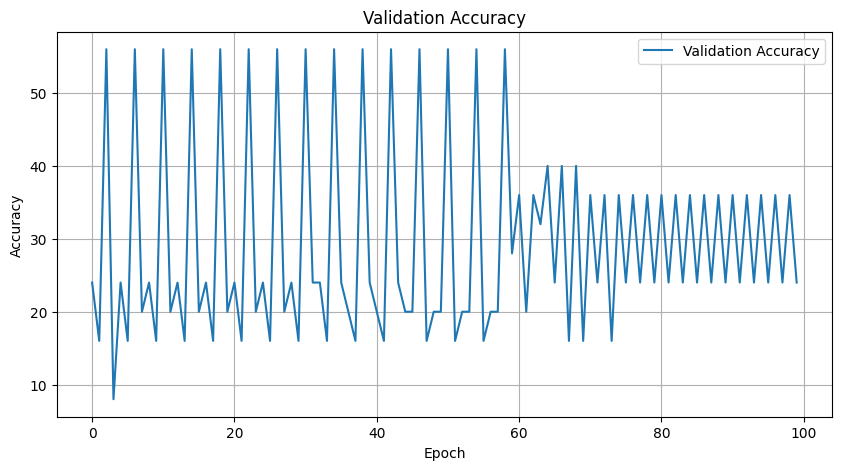

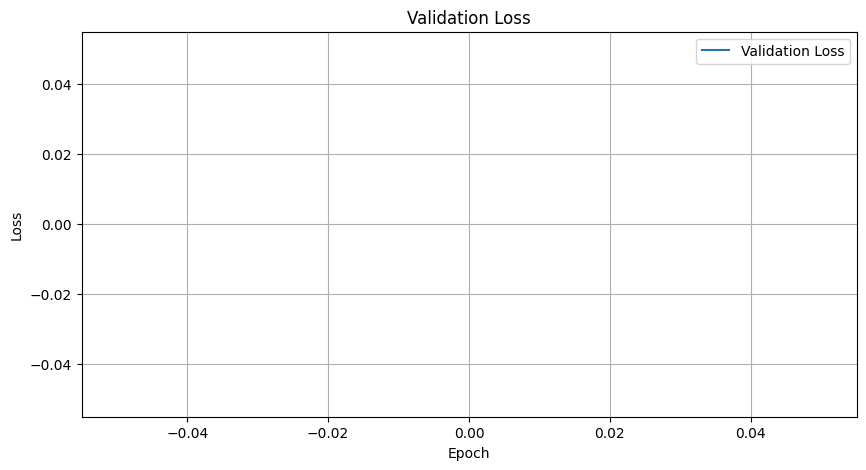

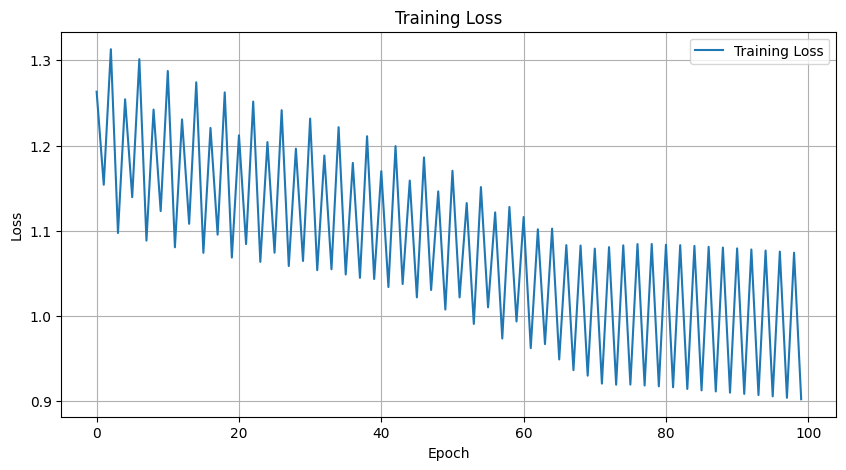

In [40]:
import matplotlib.pyplot as plt

# Plot validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation losses
plt.figure(figsize=(10, 5))
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
num_epochs = 10
for epoch in (t:=trange(num_epochs)):
    for features, labels in train_set:
        # Forward pass
        outputs = model(features)
        loss = optim(outputs, labels)
        
        # Backward pass and optimization
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

  0%|                                                                                          | 0/10 [00:00<?, ?it/s]


RuntimeError: Expected floating point type for target with class probabilities, got Long